In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'n240.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the data
print("dataset preview:")
print(data.head())

dataset preview:
   region_id                 date  temperature   humidity  wind_speed  \
0        1.0  2023-01-01 00:00:00    29.773312  84.710759    4.665236   
1        1.0  2023-01-02 00:00:00    19.267481  70.835021   16.753346   
2        1.0  2023-01-03 00:00:00    32.894305  75.852071   10.829271   
3        1.0  2023-01-04 00:00:00    26.960311  80.894930   13.943569   
4        1.0  2023-01-05 00:00:00    27.075079  65.085132   17.118529   

   rainfall vegetation_type  drough_index  previous_fire  fire_occurrence  
0  0.847981       Shrubland      0.706012            0.0              0.0  
1  2.925033       Shrubland      0.667292            0.0              0.0  
2  3.858680       Shrubland      0.625556            0.0              0.0  
3  0.717945       Shrubland      0.661796            0.0              1.0  
4  1.162567       Shrubland      0.684880            1.0              1.0  


In [64]:
# Check for missing values and data types
print("\nMissing values and data types:")
summary_table = pd.DataFrame({
    'total row' : len(data),
    'Missing Values': data.isnull().sum(),
    'Data Types': data.dtypes
})
print(summary_table)

# Statistics for numerical features
print("\nStatistics for numerical columns:")
print(data.describe())

# Target variable balance
print("\nTarget variable distribution (fire_occurrence):")
print(data['fire_occurrence'].value_counts(normalize=True))


Missing values and data types:
                 total row  Missing Values Data Types
region_id            18250             390    float64
date                 18250             349     object
temperature          18250             364    float64
humidity             18250             382    float64
wind_speed           18250             375    float64
rainfall             18250             348    float64
vegetation_type      18250             333     object
drough_index         18250             367    float64
previous_fire        18250             359    float64
fire_occurrence      18250             383    float64

Statistics for numerical columns:
          region_id   temperature      humidity    wind_speed      rainfall  \
count  17860.000000  17886.000000  17868.000000  17875.000000  17902.000000   
mean      25.517917     24.966290     50.017210     19.926352      6.074853   
std       14.442441      8.925320     22.332482     11.998242     10.179374   
min        1.000000    

# Analyze the Dataset
- Missing values ranging from 333 (**vegetation_type**) to 383 (**fire_occurrence**). <br>
- **date** is currently a string and should be converted to a proper datetime object. <br>
- **fire_occurrence** and **previous_fire** will be converted to integer types since they are binary categorical variables. <br>
- Some anomalies, such as negative values for **humidity** and **wind_speed**, which are unrealistic.

In [65]:
# Target variable: Drop rows with missing target values
data = data.dropna(subset=['fire_occurrence'])

# Convert `fire_occurrence` and `previous_fire` to integers
data['fire_occurrence'] = data['fire_occurrence'].astype(int)
data['previous_fire'] = data['previous_fire'].fillna(data['fire_occurrence'].shift(1))
data['previous_fire'] = data['previous_fire'].astype(int)

# Convert `date` to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
# Function to fill missing dates
def fill_date(df):
    for i in df[df['date'].isnull()].index: 
        # Find the date above
        date_above = df.loc[i - 1, 'date'] if i - 1 in df.index else None
        # Find the date below
        date_below = df.loc[i + 1, 'date'] if i + 1 in df.index else None
    
        if pd.notnull(date_above):
            df.loc[i, 'date'] = date_above + pd.Timedelta(days=1)
        elif pd.notnull(date_below):
            df.loc[i, 'date'] = date_below - pd.Timedelta(days=1)
    return df

# Apply the function to fill missing dates
while (data['date'].isnull().sum()>0):
    data = fill_date(data)
# Remove negative values for humidity and wind_speed
data = data[(data['humidity'] >= 0) & (data['wind_speed'] >= 0)]

# Add seasonal information to the dataset
data['season'] = data['date'].dt.month.map(
    lambda x: 'Winter' if x in [12, 1, 2] else 
        'Spring' if x in [3, 4, 5] else 
        'Summer' if x in [6, 7, 8] else'Fall'
)
print(data.describe())

          region_id                           date   temperature  \
count  16263.000000                          16612  16269.000000   
mean      25.480416  2023-07-02 05:50:01.878160128     24.949822   
min        1.000000            2023-01-01 00:00:00     -3.318065   
25%       13.000000            2023-04-02 00:00:00     18.218454   
50%       25.000000            2023-07-02 00:00:00     25.048526   
75%       38.000000            2023-10-02 00:00:00     31.746049   
max       50.000000            2024-01-01 00:00:00     53.672885   
std       14.447560                            NaN      8.933118   

           humidity    wind_speed      rainfall  drough_index  previous_fire  \
count  16612.000000  16612.000000  16285.000000  16271.000000   16612.000000   
mean      50.034753     20.611703      6.054474      0.531720       0.398989   
min        0.753814      0.000934      0.000000      0.003009       0.000000   
25%       30.093924     10.693840      0.000000      0.485288      

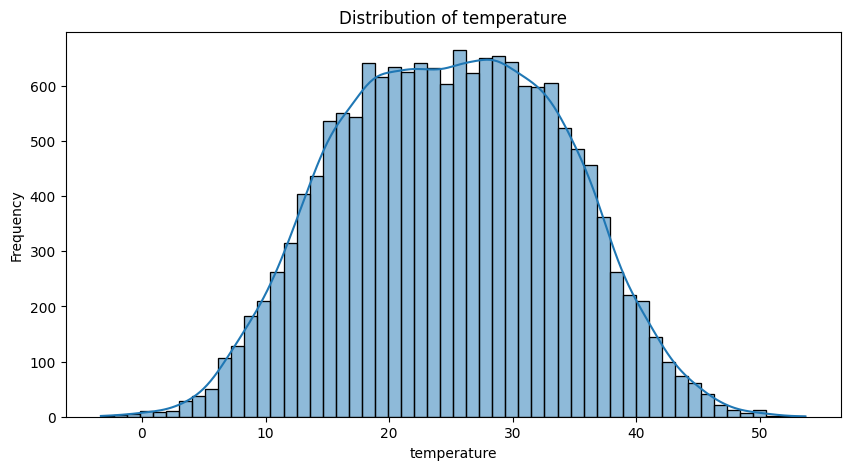

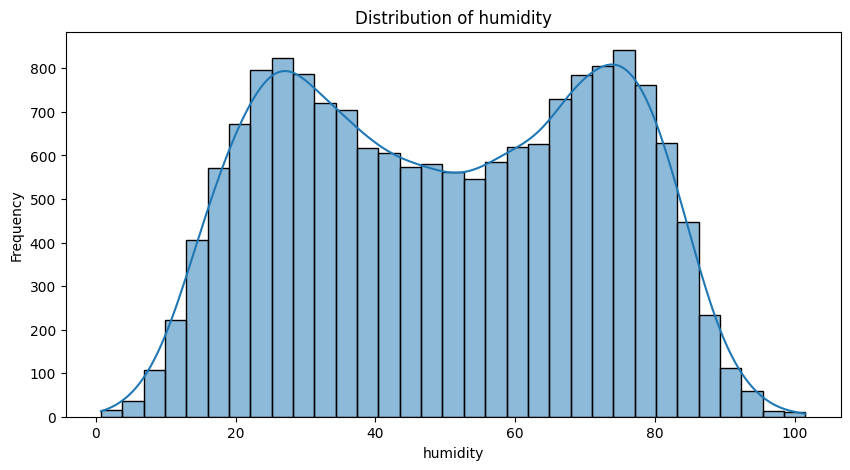

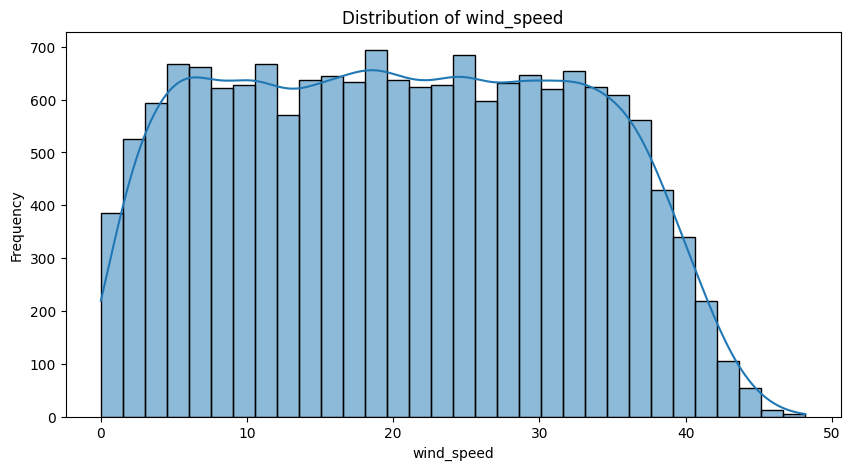

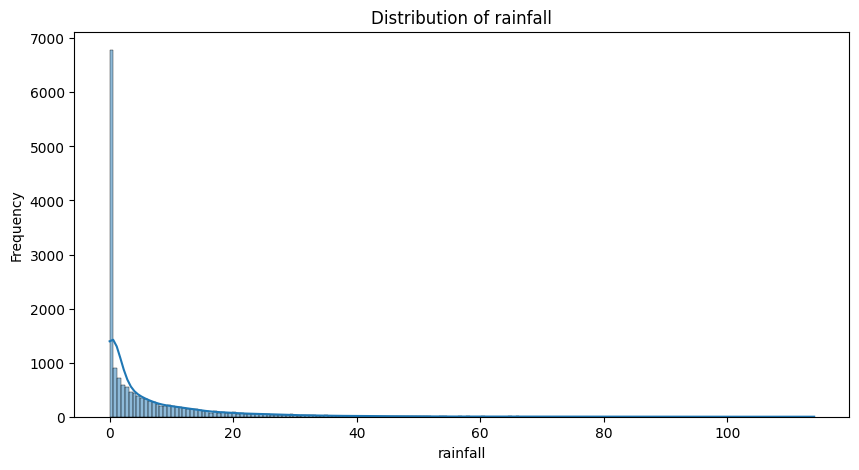

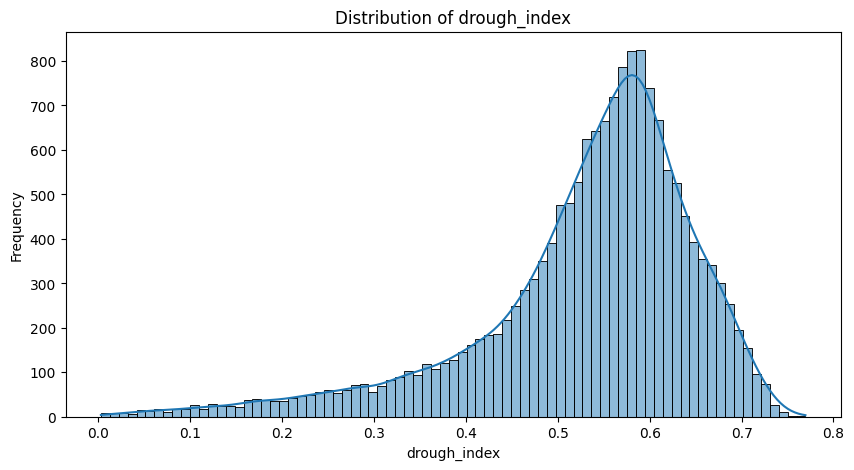

In [66]:
#Distribution of numerical features
numerical_columns = ['temperature', 'humidity', 'wind_speed', 'rainfall', 'drough_index']
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

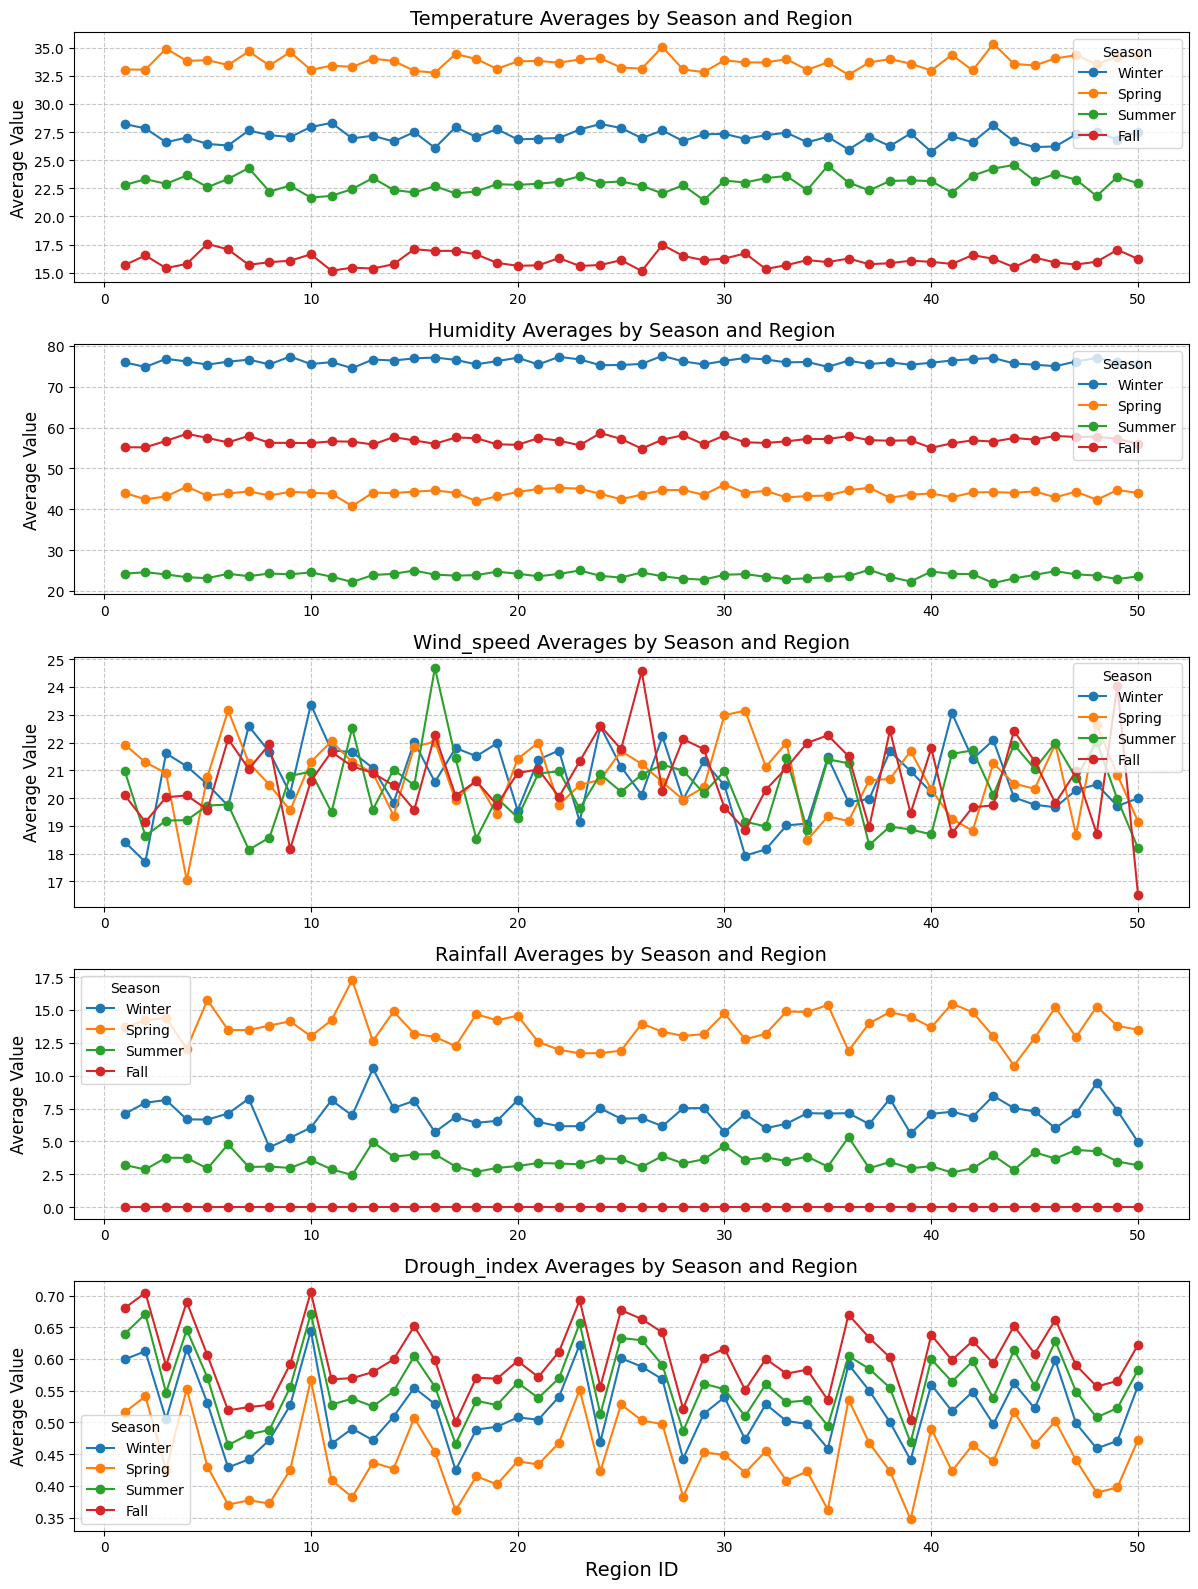

In [67]:
# Calculate the average of numerical columns grouped by region_id and season
region_season_avg = data.groupby(['region_id', 'season'])[numerical_columns].mean().reset_index()

# Plotting region_id and season averages for numerical features
fig, axs = plt.subplots(len(numerical_columns), 1, figsize=(12, 16))

for idx, col in enumerate(numerical_columns):
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_data = region_season_avg[region_season_avg['season'] == season]
        axs[idx].plot(season_data['region_id'], season_data[col], marker='o', label=season)
    axs[idx].set_title(f'{col.capitalize()} Averages by Season and Region', fontsize=14)
    axs[idx].set_ylabel('Average Value', fontsize=12)
    axs[idx].grid(True, linestyle='--', alpha=0.7)
    axs[idx].legend(title='Season', fontsize=10)

# Add shared x-label
plt.xlabel('Region ID', fontsize=14)
plt.tight_layout()
plt.show()

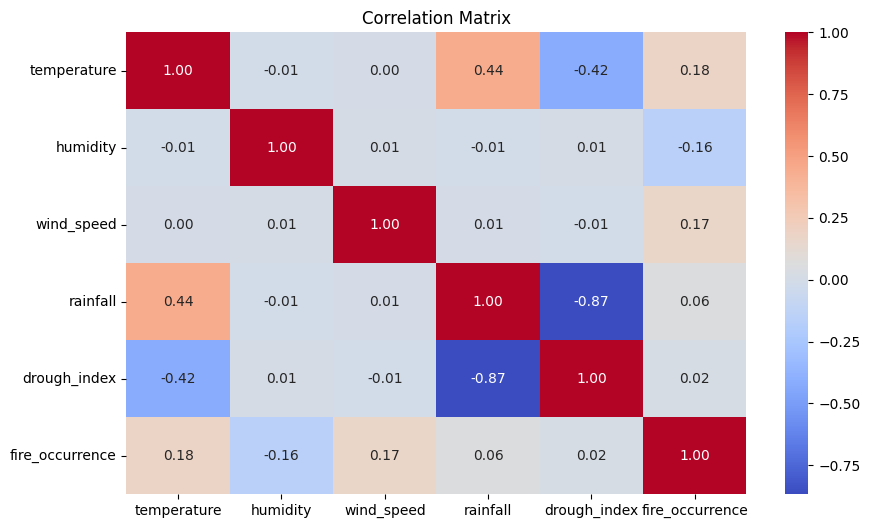

In [68]:
#Correlation analysis
correlation_matrix = data[numerical_columns + ['fire_occurrence']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

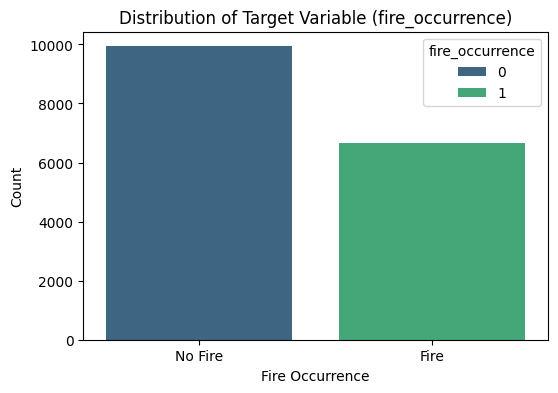

In [69]:
#Fire occurrence graph
plt.figure(figsize=(6, 4))
sns.countplot(x='fire_occurrence', data=data, palette='viridis', hue='fire_occurrence')
plt.title("Distribution of Target Variable (fire_occurrence)")
plt.xlabel("Fire Occurrence")
plt.ylabel("Count")
plt.xticks([0, 1], ['No Fire', 'Fire'])
plt.show()


Average Temperature by Fire Occurrence:
fire_occurrence
0    23.618606
1    26.931171
Name: temperature, dtype: float64


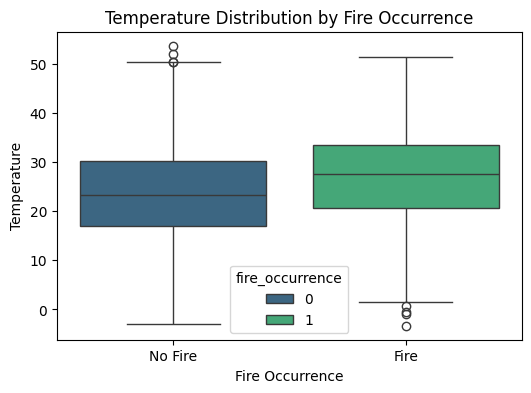

In [70]:
# Average temperature vs fire occurrence
avg_temp = data.groupby('fire_occurrence')['temperature'].mean()
print("\nAverage Temperature by Fire Occurrence:")
print(avg_temp)

plt.figure(figsize=(6, 4))
sns.boxplot(x='fire_occurrence', y='temperature', data=data, palette='viridis', hue='fire_occurrence')
plt.title("Temperature Distribution by Fire Occurrence")
plt.xlabel("Fire Occurrence")
plt.ylabel("Temperature")
plt.xticks([0, 1], ['No Fire', 'Fire'])
plt.show()

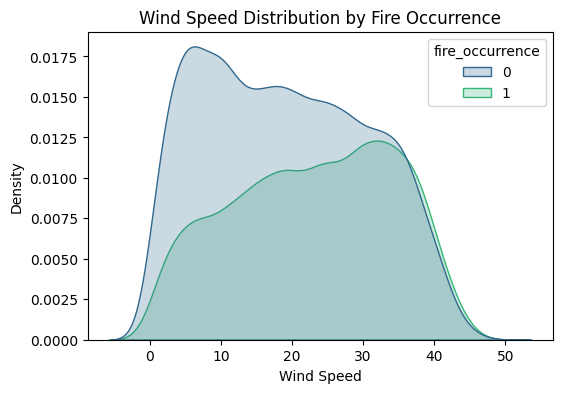

In [71]:
# Wind speed distribution based on fire occurrence
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data, x='wind_speed', hue='fire_occurrence', fill=True, palette='viridis')
plt.title("Wind Speed Distribution by Fire Occurrence")
plt.xlabel("Wind Speed")
plt.ylabel("Density")
plt.show()

**General Observation**
1. Temperature: Regions generally show consistent seasonal patterns, but some regions have more significant temperature variations across seasons.<br>
2. Humidity: Humidity varies significantly between regions, with some consistently drier regions.<br>
3. Wind Speed: Certain regions consistently experience stronger winds, which may correlate with geographic features like open plains or coastal areas.<br>
4. Rainfall: Some regions receive significantly more rainfall in specific seasons, while others remain dry throughout the year.<br>
5. Drought Index: Certain regions consistently show higher drought index values, suggesting they are more drought-prone.<br>
---
**Seasonal Patterns**<br>
- Temperature and drought peak in Summer, while rainfall is also concentrated in this season, aligning with typical climatic cycles.<br>
- Winter is marked by cooler temperatures, less rainfall, and reduced drought severity.<br>

**Regional Diversity**<br>
- Some regions exhibit more extreme seasonal variations, while others remain relatively consistent year-round.<br>
- Wind speed, and rainfall show marked regional differences.<br>

**Correlation Analysis**<br>
- Strong positive correlation between **Temperature** and **Rainfall** indicate higher temperature may associate with more rainfall<br>
- Strong negative correlation between **Rainfall** and **Drought Index** as expected since rainfall reduces drought severity.<br>
- **Fire Occurrence** negatively correlated with **Humidity**, reflecting its dampening effect on fire risk.

**Target relationship**<br>
- **Temperature:** Days with fires have a higher average temperature compared to days without fires.<br>
- **Wind Speed:** Fire days show higher wind speeds, aiding fire spread.<br>
- **Rainfall:** Fire occurrence is weakly related to rainfall, likely due to a lagged effect (previous rain reducing fire risk).<br>
# Handle Missing value
I use **K-Nearest Neighbors (KNN)** for imputing missing values in numerical columns based on each group of **region_id** and **season**<br>
I fill missing categorical values based on group of region_id using mode

In [72]:
from sklearn.impute import KNNImputer

# Select numerical columns to impute
numerical_columns = ['temperature', 'humidity', 'wind_speed', 'rainfall', 'drough_index']

# Function to apply KNN imputation to each group
def knn_impute_group(group):
    # Create a KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
    # Apply KNN imputer to numerical columns
    group[numerical_columns] = knn_imputer.fit_transform(group[numerical_columns])
    return group

# Group the dataset by `region_id` and `season` and apply KNN imputation
data = data.groupby(['region_id', 'season']).apply(knn_impute_group)
data = data.reset_index(drop=True)

# Function to fill missing categorical values of vegetation_type
def fill_categorical_value(group, column):
    # Fill missing values with the mode within the group
    mode_value = group[column].mode()
    if not mode_value.empty:
        group[column] = group[column].fillna(mode_value[0])
    return group

# Apply group-based filling for categorical columns of vegetation_type
categorical_columns = ['vegetation_type']
for col in categorical_columns:
    data = data.groupby(['region_id', 'season']).apply(fill_categorical_value, column=col)
data = data.reset_index(drop=True)


# Verify the result
print("Missing values after imputation:")
print(data.isnull().sum())


Missing values after imputation:
region_id          0
date               0
temperature        0
humidity           0
wind_speed         0
rainfall           0
vegetation_type    0
drough_index       0
previous_fire      0
fire_occurrence    0
season             0
dtype: int64


C:\Users\truon\AppData\Local\Temp\ipykernel_19256\752352103.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['region_id', 'season']).apply(knn_impute_group)
C:\Users\truon\AppData\Local\Temp\ipykernel_19256\752352103.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['region_id', 'season']).apply(fill_categorical_value, column=col)


# Handle Outliers
I remove outlier for each numerical columns ['temperature', 'humidity', 'wind_speed', 'rainfall', 'drough_index'] based on group of **region_id** and **season** attributes<br>
Method used is **Interquartile Range (IQR)** which is good for non-normal distributions, and the spread of data does not vary significantly

In [73]:
# Function to handle outliers within a group
def remove_outliers(group, col):
    Q1 = group[col].quantile(0.25)
    Q3 = group[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers outside the range [lower_bound, upper_bound]
    return group[(group[col] >= lower_bound) & (group[col] <= upper_bound)]
# shape before remove outliers
print("Data shape before outlier removal:", data.shape)
# Apply the outlier removal to each group
for col in numerical_columns:
    data = data.groupby(['region_id', 'season'], group_keys=False).apply(remove_outliers, col=col)

# Verify the result
print("Data shape after outlier removal:", data.shape)

Data shape before outlier removal: (16263, 11)


C:\Users\truon\AppData\Local\Temp\ipykernel_19256\1039002262.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['region_id', 'season'], group_keys=False).apply(remove_outliers, col=col)
C:\Users\truon\AppData\Local\Temp\ipykernel_19256\1039002262.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['region_id', 'season'], group_keys=False).apply(remove_outliers, c

Data shape after outlier removal: (14774, 11)


C:\Users\truon\AppData\Local\Temp\ipykernel_19256\1039002262.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['region_id', 'season'], group_keys=False).apply(remove_outliers, col=col)


# Encoding Categorial Features


In [74]:
# One-hot encode categorical variables
data['region_id'] = data['region_id'].astype(int)
data = pd.get_dummies(data, columns=['vegetation_type', 'season'])

In [75]:
print("Processed Data Summary:")
print(data.info())

Processed Data Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 14774 entries, 0 to 16262
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   region_id                          14774 non-null  int64         
 1   date                               14774 non-null  datetime64[ns]
 2   temperature                        14774 non-null  float64       
 3   humidity                           14774 non-null  float64       
 4   wind_speed                         14774 non-null  float64       
 5   rainfall                           14774 non-null  float64       
 6   drough_index                       14774 non-null  float64       
 7   previous_fire                      14774 non-null  int64         
 8   fire_occurrence                    14774 non-null  int64         
 9   vegetation_type_Coniferous Forest  14774 non-null  bool          
 10  vegetation_type

# Building Model 

**Data Splitting**<br>
I splitted data into training set and testing set

In [76]:
# Features (X) and target (y)
X = data.drop(columns=['fire_occurrence', 'date'])
y = data['fire_occurrence']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model 1 - Logistic Regression & evaluation**<br>


In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train Logistic Regression
logistic_model = LogisticRegression(penalty=None, max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
logistic_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_logistic),
    'Precision': precision_score(y_test, y_pred_logistic),
    'Recall': recall_score(y_test, y_pred_logistic),
    'F1 Score': f1_score(y_test, y_pred_logistic)
}

print("Logistic Regression Metrics:")
print(logistic_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))

Logistic Regression Metrics:
{'Accuracy': 0.7898477157360406, 'Precision': np.float64(0.7601851851851852), 'Recall': np.float64(0.6939983093829247), 'F1 Score': np.float64(0.7255855059655325)}

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1772
           1       0.76      0.69      0.73      1183

    accuracy                           0.79      2955
   macro avg       0.78      0.77      0.78      2955
weighted avg       0.79      0.79      0.79      2955



**Model 2 - Decision Tree Classifier & Evaluation**

In [78]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = decision_tree_model.predict(X_test)

# Evaluate the model
tree_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_tree),
    'Precision': precision_score(y_test, y_pred_tree),
    'Recall': recall_score(y_test, y_pred_tree),
    'F1 Score': f1_score(y_test, y_pred_tree)
}

print("Decision Tree Metrics:")
print(tree_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Metrics:
{'Accuracy': 0.6906937394247039, 'Precision': np.float64(0.6140797285835454), 'Recall': np.float64(0.6120033812341504), 'F1 Score': np.float64(0.6130397967823878)}

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      1772
           1       0.61      0.61      0.61      1183

    accuracy                           0.69      2955
   macro avg       0.68      0.68      0.68      2955
weighted avg       0.69      0.69      0.69      2955



**Model 3 - Random Forest Classifier & Evaluation**

In [79]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred_forest = random_forest_model.predict(X_test)

# Evaluate the model
forest_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_forest),
    'Precision': precision_score(y_test, y_pred_forest),
    'Recall': recall_score(y_test, y_pred_forest),
    'F1 Score': f1_score(y_test, y_pred_forest)
}

print("Random Forest Metrics:")
print(forest_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_forest))

Random Forest Metrics:
{'Accuracy': 0.7824027072758037, 'Precision': np.float64(0.7662721893491125), 'Recall': np.float64(0.6568047337278107), 'F1 Score': np.float64(0.7073281747837961)}

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1772
           1       0.77      0.66      0.71      1183

    accuracy                           0.78      2955
   macro avg       0.78      0.76      0.77      2955
weighted avg       0.78      0.78      0.78      2955



**I chose Random Forest Classifier because it**
- Handles non-linear interactions and mixed data types effectively.
- Provides high accuracy, recall, and feature importance for actionable insights. (I did test with NaiveBayes, and KNN)<br>

**Implications of Metrics for Forest Fire Prediction**

- A model with high precision but low recall might miss actual fires (false negatives), leading to dangerous outcomes.
- A model with high recall but low precision might cause false alarms (false positives), wasting resources.
- In this context, **recall** is more important, as missing an actual fire could have catastrophic consequences.
- **F1 Score** balances **precision** and **recall**, making it an ideal metric for evaluating model performance in fire prediction.
- **accuracy** might be misleading if the dataset is imbalanced (e.g., more "no fire" cases than "fire").

In [80]:
# Combine metrics from all models
metrics_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [logistic_metrics['Accuracy'], tree_metrics['Accuracy'], forest_metrics['Accuracy']],
    'Precision': [logistic_metrics['Precision'], tree_metrics['Precision'], forest_metrics['Precision']],
    'Recall': [logistic_metrics['Recall'], tree_metrics['Recall'], forest_metrics['Recall']],
    'F1 Score': [logistic_metrics['F1 Score'], tree_metrics['F1 Score'], forest_metrics['F1 Score']]
})

print(metrics_summary)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.789848   0.760185  0.693998  0.725586
1        Decision Tree  0.690694   0.614080  0.612003  0.613040
2        Random Forest  0.782403   0.766272  0.656805  0.707328


# Feature Important

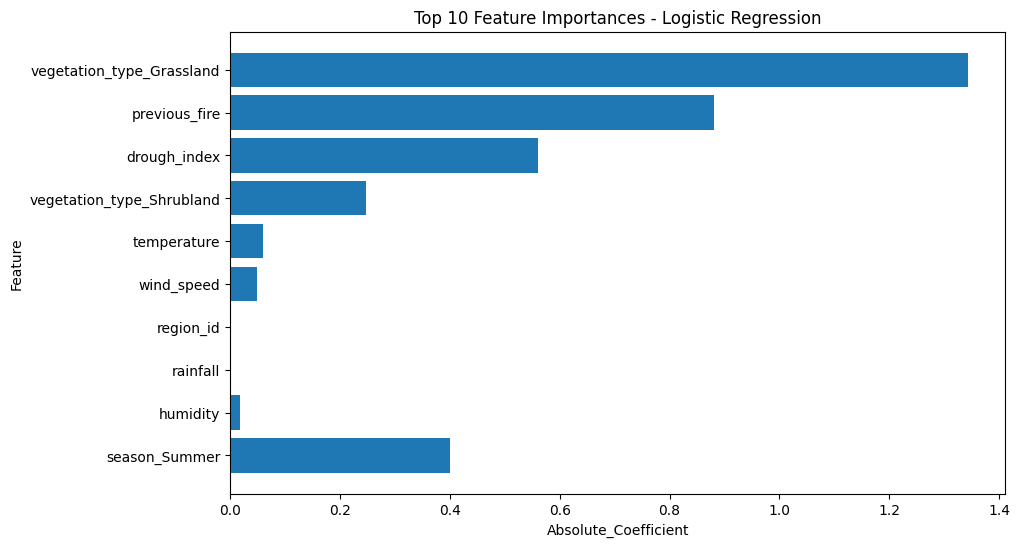

                      Feature  Coefficient  Absolute_Coefficient
9   vegetation_type_Grassland     1.344021              1.344021
6               previous_fire     0.881540              0.881540
5                drough_index     0.559934              0.559934
11  vegetation_type_Shrubland     0.246898              0.246898
1                 temperature     0.059162              0.059162
3                  wind_speed     0.048860              0.048860
0                   region_id     0.002029              0.002029
4                    rainfall     0.000241              0.000241
2                    humidity    -0.016844              0.016844
14              season_Summer    -0.399302              0.399302


In [81]:
import numpy as np

# Extract feature coefficients
coefficients = logistic_model.coef_[0]
features = X.columns

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
}).sort_values(by='Coefficient', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Absolute_Coefficient'][:10])
plt.xlabel('Absolute_Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# Display the top 10 most important features
print(feature_importance.head(10))

# Insights and Recommendations
- Features with high positive coefficients (Grassland and Shrubland type, previous_fire, drought_index, temperature) strongly correlate with fire occurrence.
- Focus on areas with high temperatures, strong winds, low humidity, and high drought indices.
- Monitor regions with previous fires closely, as they are more likely to experience subsequent fires.
- High-risk seasons (Summer) and allocate resources accordingly.
- Target specific regions with high-risk vegetation types (Grasslands, Shrubland).
- Use the model for real-time predictions to trigger alerts during high-risk conditions.


In [ ]:
import joblib

# Save the trained model and feature preprocessing pipeline
joblib.dump(logistic_model, 'logistic_model.pkl')
joblib.dump(X.columns, 'model_features.pkl') 

['model_features.pkl']